In [1]:
%load_ext blackcellmagic

In [2]:
%%javascript
require(
        ["notebook/js/outputarea"],
        function (oa) {
            oa.OutputArea.auto_scroll_threshold = -1;
            console.log("Setting auto_scroll_threshold to -1");
        });

<IPython.core.display.Javascript object>

In [10]:
#%%writefile crawto/CrawtoDS.py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from math import ceil
import pandas as pd
from sklearn.metrics import classification_report
from scipy.stats import shapiro, boxcox, yeojohnson
from scipy.stats import probplot
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer
from crawto.classification_visualization import classification_visualization
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

sns.set_palette("colorblind")
import warnings

warnings.filterwarnings("ignore")


class CrawtoDS:
    def __init__(
        self,
        data,
        target,
        hold_out_data=None,
        time_dependent=False,
        features="infer",
        problem="infer",
    ):
        self.input_data = data
        self.target = target
        self.features = features
        self.problem = problem
        self.hold_out_data = hold_out_data
        self.timedependent = time_dependent
        self.train_data, self.test_data = train_test_split(
            self.input_data, shuffle=True, stratify=self.input_data[self.target]
        )

    @property
    def nan_features(self):
        """a little complicated. map creates a %nan values and returns the feature if greater than the threshold.
        filter simply filters out the false values """
        f = self.input_data.columns.values
        len_df = len(self.input_data)
        nan_features = list(
            filter(
                lambda x: x is not False,
                map(
                    lambda x: x
                    if self.input_data[x].isna().sum() / len_df > 0.25
                    else False,
                    f,
                ),
            )
        )
        return nan_features

    @property
    def problematic_features(self):
        f = self.input_data.columns.values
        problematic_features = []
        for i in f:
            if "Id" in i:
                problematic_features.append(i)
            elif "ID" in i:
                problematic_features.append(i)
        return problematic_features

    @property
    def undefined_features(self):
        if self.features == "infer":
            undefined_features = list(self.input_data.columns)
            undefined_features.remove(self.target)
        for i in self.nan_features:
            undefined_features.remove(i)
        for i in self.problematic_features:
            undefined_features.remove(i)
        return undefined_features

    @property
    def numeric_features(self):
        numeric_features = []
        l = self.undefined_features
        for i in l:
            if self.input_data[i].dtype in ["float64", "float", "int", "int64"]:
                numeric_features.append(i)
        return numeric_features

    @property
    def categorical_features(self, threshold=10):
        self.undefined_features
        categorical_features = []
        to_remove = []
        l = self.undefined_features
        for i in l:
            if len(self.input_data[i].value_counts()) / len(self.input_data[i]) < 0.10:
                categorical_features.append(i)
        return categorical_features

    #     @categorical_features.setter
    #     def categorical_features(self,new_categorical_features_list):
    #         #self.categorical_features = new_categorical_features_list
    #         #self.
    #         return new_categorical_features_list

    @property
    def indicator(self):
        indicator = MissingIndicator(features="all")
        indicator.fit(self.train_data[self.undefined_features])
        return indicator

    @property
    def train_missing_indicator_df(self):
        x = self.indicator.transform(self.train_data[self.undefined_features])
        x_labels = ["missing_" + i for i in self.undefined_features]
        missing_indicator_df = pd.DataFrame(x, columns=x_labels)
        columns = [
            i
            for i in list(missing_indicator_df.columns.values)
            if missing_indicator_df[i].max() == True
        ]
        return missing_indicator_df[columns].replace({True: 1, False: 0})

    @property
    def test_missing_indicator_df(self):
        x = self.indicator.transform(self.test_data[self.undefined_features])
        x_labels = ["missing_" + i for i in self.undefined_features]
        missing_indicator_df = pd.DataFrame(x, columns=x_labels)
        columns = list(self.train_missing_indicator_df)
        return missing_indicator_df[columns].replace({True: 1, False: 0})

    @property
    def numeric_imputer(self):
        numeric_imputer = SimpleImputer(strategy="median", copy=True)
        numeric_imputer.fit(self.train_data[self.numeric_features])
        return numeric_imputer

    @property
    def categorical_imputer(self):
        categorical_imputer = SimpleImputer(strategy="most_frequent", copy=True)
        categorical_imputer.fit(self.train_data[self.categorical_features])
        return categorical_imputer

    @property
    def train_imputed_numeric_df(self):
        x = self.numeric_imputer.transform(self.train_data[self.numeric_features])
        x_labels = [i + "_imputed" for i in self.numeric_features]
        imputed_numeric_df = pd.DataFrame(x, columns=x_labels)
        return imputed_numeric_df

    @property
    def test_imputed_numeric_df(self):
        x = self.numeric_imputer.transform(self.test_data[self.numeric_features])
        x_labels = [i + "_imputed" for i in self.numeric_features]
        imputed_numeric_df = pd.DataFrame(x, columns=x_labels)
        return imputed_numeric_df

    @property
    def yeo_johnson_transformer(self):
        yeo_johnson_transformer = PowerTransformer(method="yeo-johnson", copy=True)
        yeo_johnson_transformer.fit(self.train_imputed_numeric_df)
        return yeo_johnson_transformer

    @property
    def train_yeojohnson_df(self):
        yj = self.yeo_johnson_transformer.transform(self.train_imputed_numeric_df)
        columns = self.train_imputed_numeric_df.columns.values
        columns = [i + "_yj" for i in columns]
        yj = pd.DataFrame(yj, columns=columns)
        return yj

    @property
    def test_yeojohnson_df(self):
        yj = self.yeo_johnson_transformer.transform(self.test_imputed_numeric_df)
        columns = self.test_imputed_numeric_df.columns.values
        columns = [i + "_yj" for i in columns]
        yj = pd.DataFrame(yj, columns=columns)
        return yj

    @property
    def train_imputed_categorical_df(self):
        x = self.categorical_imputer.transform(
            self.train_data[self.categorical_features]
        )
        x_labels = [i + "_imputed" for i in self.categorical_features]
        imputed_categorical_df = pd.DataFrame(x, columns=x_labels)
        return imputed_categorical_df

    @property
    def test_imputed_categorical_df(self):
        x = self.categorical_imputer.transform(
            self.test_data[self.categorical_features]
        )
        x_labels = [i + "_imputed" for i in self.categorical_features]
        imputed_categorical_df = pd.DataFrame(x, columns=x_labels)
        return imputed_categorical_df

    @property
    def target_encoder(self):
        te = TargetEncoder(cols=self.train_imputed_categorical_df.columns.values)
        te.fit(X=self.train_imputed_categorical_df, y=self.train_data[self.target])
        return te

    #     def target_encoder(self):
    #         target_encoder = TargetEncoder(x=predictor, y=response,
    #                                fold_column="fold",
    #                                blended_avg= True,
    #                                inflection_point = 3,
    #                                smoothing = 1,
    #                                seed=1234)
    #         target_encoder.fit(self.train_imputed_categorical_df)

    #     @property
    #     def labelencoded_df(self):
    #         return self.labelencoder.transform(self.imputed_categorical_df)

    @property
    def train_target_encoded_df(self):
        te = self.target_encoder.transform(self.train_imputed_categorical_df)
        columns = list(
            map(
                lambda x: re.sub(r"_imputed", "_target_encoded", x),
                list(self.train_imputed_categorical_df.columns.values),
            )
        )
        te = pd.DataFrame(data=te)
        te.columns = columns
        return te

    @property
    def test_target_encoded_df(self):
        te = self.target_encoder.transform(self.test_imputed_categorical_df)
        columns = list(
            map(
                lambda x: re.sub(r"_imputed", "_target_encoded", x),
                list(self.test_imputed_categorical_df.columns.values),
            )
        )
        te = pd.DataFrame(data=te)
        te.columns = columns
        return te

    def correlation_report(self):
        sns.heatmap(self.input_data[self.numeric_features].corr())

    def target_distribution_report(self):
        if self.problem == "regression":
            return sns.distplot(self.input_data[self.target])
        elif self.problem == "classification":
            return sns.countplot(self.input_data[self.target])

    def numeric_columns_distribution_report(self):
        return self.distribution_r()

    def distribution_r(self):
        display(
            pandas.DataFrame(
                [
                    self.distribution_fit(self.input_data, i)
                    for i in self.numeric_features + [self.target]
                ],
                index=self.numeric_features + [self.target],
            )
        )

    def distribution_fit(self, data, numeric_features):
        """
        x is a column_name
        """
        shapiro_values = shapiro(data[numeric_features])
        test_indication = True if shapiro_values[1] > 0.05 else False

        distribution_types = ["norm", "expon", "logistic", "gumbel"]
        # anderson_values = anderson(automl.data[numeric_column], dist=i)

        return {
            "Shapiro-Wilks_Test_Statistic": shapiro_values[0],
            "Shapiro-Wilks_p_Value": shapiro_values[1],
            "Normal distribution ?": test_indication
            # "Anderson_Darling_Test_Statistic_Normal": anderson_values[0][0],
        }

    def nan_report(self):
        return display(
            pandas.DataFrame(
                round(
                    (self.input_data.isna().sum() / self.input_data.shape[0]) * 100, 2
                ),
                columns=["Percent of data encoded NAN"],
            )
        )

    def skew_report(dataframe, threshold=5):
        highly_skewed = [
            i[0]
            for i in zip(
                dataframe.columns.values, abs(dataframe.skew(numeric_only=True))
            )
            if i[1] > threshold
        ]
        print(
            "There are %d highly skewed data columns. Please check them for miscoded na's"
            % len(highly_skewed)
        )
        print(highly_skewed)

    def correlation_report(self, threshold=0.95):
        corr_matrix = self.input_data[[self.target] + self.numeric_features].corr()
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
        )
        highly_correlated_features = [
            column for column in upper.columns if any(upper[column] > threshold)
        ]
        sns.heatmap(corr_matrix)
        if len(highly_correlated_features) > 0:
            return f"Highly Correlated features are {highly_correlated_features}"
        else:
            return "No Features are correlated above the threshold"

    def probability_plots(self):
        c = list(self.imputed_numeric_df.columns.values)
        c.sort()
        c.remove(self.target)
        fig = plt.figure(figsize=(12, len(c) * 4))
        fig.tight_layout()
        chart_count = 1
        for i in range(1, (len(c) + 1), 1):
            fig.add_subplot(len(c), 2, chart_count)
            chart_count += 1
            probplot(self.imputed_numeric_df[c[i - 1]], plot=plt)
            plt.subplots_adjust(
                left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.35
            )
            plt.title(c[i - 1] + " Probability Plot")
            fig.add_subplot(len(c), 2, chart_count)
            chart_count += 1
            sns.distplot(self.imputed_numeric_df[c[i - 1]])
            plt.show()

    def categorical_bar_plots(self):
        data = self.imputed_categorical_df.merge(
            self.input_data[self.target], left_index=True, right_index=True, sort=True
        )
        c = list(data.columns.values)
        c.sort()
        fig = plt.figure(figsize=(12, len(c) * 4))
        fig.tight_layout()
        chart_count = 1
        for i in range(1, len(c) + 1):
            fig.add_subplot(len(c), 2, chart_count)
            sns.barplot(x=c[i - 1], y=self.target, data=data)
            chart_count += 1
            fig.add_subplot(len(c), 2, chart_count)
            sns.countplot(x=c[i - 1], data=data)
            chart_count += 1

    def baseline_prediction(self):
        if self.problem == "classification":
            y_pred = np.dot(
                np.ones_like(self.test_data[self.target]).reshape(-1, 1),
                np.array(self.train_data[self.target].mode()).reshape(-1, 1),
            )
            classification_visualization(self.test_data[self.target], y_pred)
        if self.problem == "regression":
            pass

    def naive_regression(self):
        if self.problem == "classification":
            lr = LogisticRegression(penalty="none", C=0.0, solver="lbfgs")

            train_naive_data = self.train_target_encoded_df.merge(
                self.train_imputed_categorical_df, left_index=True, right_index=True
            ).merge(self.train_missing_indicator_df, left_index=True, right_index=True)

            test_naive_data = self.test_target_encoded_df.merge(
                self.test_imputed_categorical_df, left_index=True, right_index=True
            ).merge(self.test_missing_indicator_df, left_index=True, right_index=True)

            lr.fit(train_naive_data, self.train_data[self.target])
            y_pred = lr.predict(test_naive_data)
            classification_visualization(y_pred, self.test_data[self.target])

    def transformed_regression(self):
        if self.problem == "classification":
            lr = LogisticRegression(penalty="none", C=0.0, solver="lbfgs")

            train_naive_data = (
                self.train_target_encoded_df.merge(
                    self.train_yeojohnson_df, left_index=True, right_index=True
                )
                .merge(
                    self.train_missing_indicator_df, left_index=True, right_index=True
                )
                .replace(np.nan, 0)
            )

            test_naive_data = (
                self.test_target_encoded_df.merge(
                    self.test_yeojohnson_df, left_index=True, right_index=True
                )
                .merge(
                    self.test_missing_indicator_df, left_index=True, right_index=True
                )
                .replace(np.nan, 0)
            )

            lr.fit(train_naive_data, self.train_data[self.target])
            y_pred = lr.predict(test_naive_data)
            classification_visualization(y_pred, self.test_data[self.target])
            # return train_naive_data, test_naive_data

    def __repr__(self):
        s = f"\ttarget: {self.target}\n\
        undefined features: {self.undefined_features}\n\
        nan features: {self.nan_features}\n\
        problematic features: {self.problematic_features}\n\
        numeric_features: {self.numeric_features}\n\
        categorical_features: {self.categorical_features}"
        return s

Overwriting crawto/CrawtoDS.py


In [4]:
import pandas
df = pandas.read_csv("train.csv")

In [5]:
c = CrawtoDS(
    data=df,
    target="Survived",
    problem='classification'
)

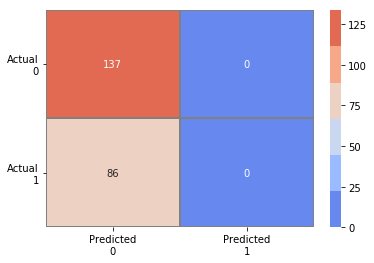

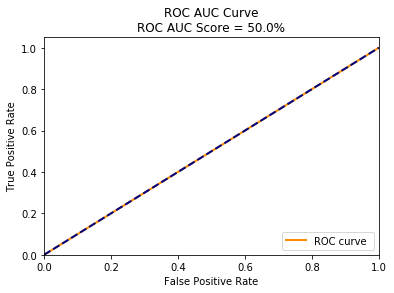

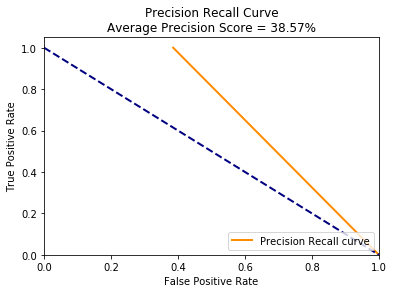

In [6]:
c.baseline_prediction()

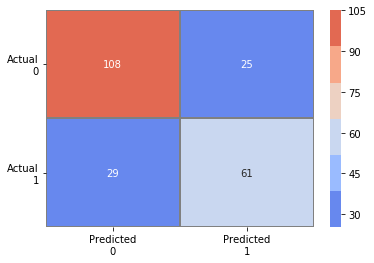

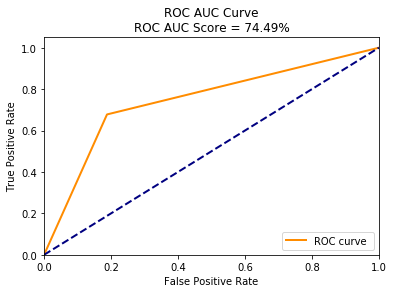

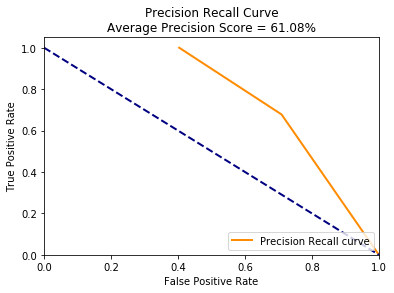

In [7]:
c.transformed_regression()